In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [3]:
tickers = ['SPY', 'BND', 'QQQ', 'GLD', 'AAPL', 'VTI', 'NVDA', 'GOOG', 'AMZN', 'MSFT']
end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)

In [4]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [6]:
cov_matrix = log_returns.cov()*252

In [15]:
def std(weight, cov):
    variance = weight.T @ cov @ weight
    return np.sqrt(variance)
def expected(weight, log):
    return np.sum(log.mean()*weight)*252
def Sharpe_ratio (weight, log, cov, risk):
    return -(expected(weight,log)-risk)/std(weight, cov)

In [11]:
from fredapi import Fred

In [12]:
fred = Fred(api_key='67de114e17594ffc6b266533afb2dadd')
ten_year = fred.get_series_latest_release('GS10') / 100
risk_free_rate = ten_year.iloc[-1]

In [14]:
constraints = {'type':'eq', 'fun': lambda weight: np.sum(weight) - 1}
bounds = [(0,0.5) for i in range(len(tickers))]

In [16]:
weight_init = np.array([1/len(tickers)]*len(tickers))
op = minimize(Sharpe_ratio, weight_init, args=(log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds=bounds)

In [17]:
optimal_weight = op.x

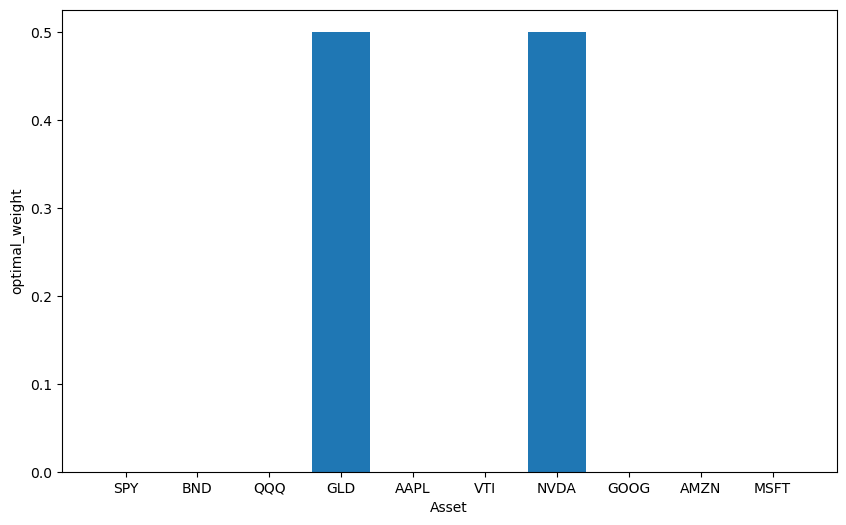

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weight)
plt.xlabel('Asset')
plt.ylabel('optimal_weight')
plt.show()